<a href="https://colab.research.google.com/github/hannahgooden/readthedocs-sandbox/blob/main/examples/ezmsg_intro_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ezmsg
import ezmsg.core as ez
from dataclasses import dataclass
from typing import AsyncGenerator, Tuple 
# Hannah!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 kB 9.1 MB/s eta 0:00:00


## Ezmsg Introduction

If this is your first time using `ezmsg`, you're in the right place. This notebook will walk through the basics of creating a very simple `ezmsg` system.

`ezmsg` is ideal for creating modular processing pipelines whose steps can be arranged as a directed acyclic graph. In this notebook, we will walk through a very simple graph which generates a count of numbers, adds 1 to each number, and prints to standard output.

# 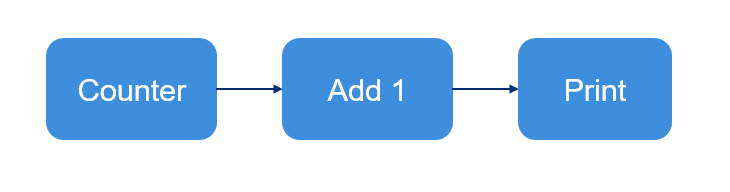

In `ezmsg` syntax, this graph would look like this:

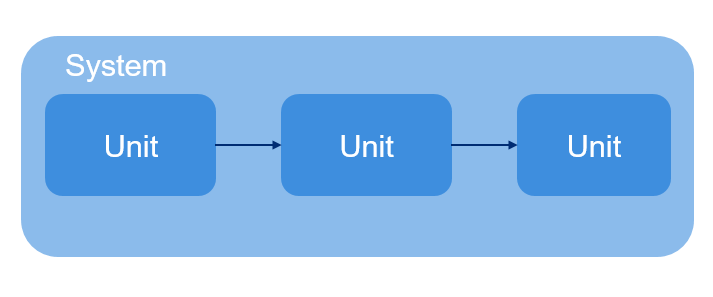

We will write an `ezmsg` `Unit` for each discrete step of our pipeline, and connect them together with a `System`.

Create a message type to pass between the `Units`. Python dataclasses are great for arbitrary messages, but you can use any type.

In [ ]:
@dataclass
class CountMessage:
    value: int

We also need a way to tell the `Unit` how many numbers to generate. All classes that derive from `ez.Settings` are frozen dataclasses!

In [ ]:
class CountSettings(ez.Settings):
   iterations: int

Next, create a `Unit` that will generate the count. Every `Unit` represents a node in the directed acyclic graph and should contain inputs and/or outputs and at least one function which subscribes to the inputs or publishes to the outputs. 

For `Count`, we create an `OutputStream` and a publishing function which will perform the number calculation and yield `CountMessages` to the `OutputStream`.

In [ ]:
class Count(ez.Unit):

    # Only provide a settings type, do not instantiate
    # The Unit should receive settings from the System that uses it
    # SETTINGS is a special/reserved class attribute for ez.Unit
    SETTINGS: CountSettings

    OUTPUT_COUNT = ez.OutputStream(CountMessage)

    @ez.publisher(OUTPUT_COUNT)
    async def count(self) -> AsyncGenerator:
        count = 0
        while count < self.SETTINGS.iterations:
            yield (self.OUTPUT_COUNT, CountMessage(
                value=count
            ))
            count = count + 1
        
        raise ez.NormalTermination

The next `Unit` in the chain should accept a `CountMessage` from the first `Unit`, add 1 to its value, and yield a new CountMessage. To do this, we create a new `Unit` which contains a function which both subscribes and publishes. We will connect this `Unit` to `Count` later on, when we create a `System`.

The subscribing function will be called anytime the `Unit` receives a message to the `InputStream` that the function subscribes to. In this case, `INPUT_COUNT`.

In [ ]:
class AddOne(ez.Unit):

    INPUT_COUNT = ez.InputStream(CountMessage)
    OUTPUT_PLUS_ONE = ez.OutputStream(CountMessage)

    @ez.subscriber(INPUT_COUNT)
    @ez.publisher(OUTPUT_PLUS_ONE)
    async def on_message(self, message) -> AsyncGenerator:
        yield (self.OUTPUT_PLUS_ONE, CountMessage(
            value=message.value + 1
        ))

Finally, the last unit should print the value of any messages it receives.

In [ ]:
class PrintValue(ez.Unit):

    INPUT = ez.InputStream(CountMessage)

    @ez.subscriber(INPUT)
    async def on_message(self, message) -> None:
        print(message.value)

The last thing to do before we have a fully functioning `ezmsg` pipeline is to define any `Settings` that have been declared and to connect all of the units together. We do this using a `Collection`. The `configure()` and `network()` functions are special functions that define `Collection` behavior.

In [ ]:
class CountCollection(ez.Collection):

    # Define member units
    COUNT = Count()
    ADD_ONE = AddOne()
    PRINT = PrintValue()

    # Use the configure function to apply settings to member Units
    def configure(self) -> None:
        self.COUNT.apply_settings(
            CountSettings(iterations=20)
        )

    # Use the network function to connect inputs and outputs of Units
    def network(self) -> ez.NetworkDefinition:
        return (
            (self.COUNT.OUTPUT_COUNT, self.ADD_ONE.INPUT_COUNT),
            (self.ADD_ONE.OUTPUT_PLUS_ONE, self.PRINT.INPUT)
        )


Finally, instantiate and run the system!

In [ ]:
collection = CountCollection()
ez.run(collection)

2023-04-17 14:20:47.572 - pid: 148 - MainThread - WARNING - run: Passing a single Component without naming the Component is now Deprecated.
2023-04-17 14:20:47.716 - pid: 148 - TaskThread - INFO - wrapped_task: Normal Termination raised in SYSTEM/COUNT:count
INFO:ezmsg:Normal Termination raised in SYSTEM/COUNT:count
2023-04-17 14:20:47.734 - pid: 148 - MainThread - INFO - run: All processes exited normally
INFO:ezmsg:All processes exited normally


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
